## Interpretation of Transfer Learning model trained on UniRef90 dataset
### Pre-training: MLM using TransformerEncoder
### Fine-tuning: Pretrained TransformerEncoder + FFN-4L

In [1]:
import sys
import os

sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/uniref90',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/uniref90/../../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/uniref90/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/uniref90/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/uniref90/..']

In [2]:
from models.nlp.transformer import transformer
from src.utils import utils, nn_utils, dataset_utils
from src.training import pre_training_masked_language_modeling
from src.training.fine_tuning import host_prediction

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE



In [3]:
input_dir = "/home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/splits/s79221635"
train_file_names = ["uniref90_final.csv_tr0.8_train.csv"]
test_file_names = ["uniref90_final.csv_tr0.8_test.csv"]

label_groupings = {"Human": [ "Homo sapiens" ],
                  "Desert warthog": [ "Phacochoerus aethiopicus" ],
                  "Lesser bandicoot rat": [ "Bandicota bengalensis" ],
                  "Horse": [ "Equus caballus" ],
                  "Goat": [ "Capra hircus" ],
                  "Red junglefowl": [ "Gallus gallus" ],
                  "Wood mouse": [ "Apodemus sylvaticus" ],
                  "Cattle": [ "Bos taurus" ],
                  "Others": [ "*" ]}
host_classes = ["Homo sapiens",  "Phacochoerus aethiopicus",    "Bandicota bengalensis",     "Equus caballus",   "Capra hircus", 
                "Gallus gallus",   "Apodemus sylvaticus",     "Bos taurus",  "Others"]

amino_acid_idx_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                  'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                  'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                  'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                  'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                  'J': 26}
idx_amino_acid_map = {v:k for k,v in amino_acid_idx_map.items()}

train_sequence_settings =  {
    "sequence_col": "seq",
    "batch_size": 8,
    "max_sequence_length": 1114,
    "pad_sequence_val": 0,
    "truncate": True,
    "feature_type": "token",
    "pad_token_val": 0
}

test_sequence_settings =  train_sequence_settings.copy()
test_sequence_settings["batch_size"] = 1

label_settings = {
    "label_col": "virus_host_name",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

encoder_settings = {
    "n_heads": 8,
    "depth": 6,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024,
    "n_tokens": 28,
    "max_seq_len": 1114
}


mlm_settings = {
    "no_mask_token_vals": [ 0 ],
    "n_tokens": 26,
    "mask_prob": 0.15,
    "random_mask_prob": 0.1,
    "no_change_mask_prob": 0.1,
    "encoder_dim": 512,
    "pad_token_val": 0
}

fine_tune_settings = {
    "depth": 4,
    "n_classes": 9,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024
}

### Load the datasets

### Training-based interpretation
#### Encoding visualization - all viruses, all hosts

In [4]:
def compute_dataset_representations(model, dataset_loader):
    model.eval()
    seq_dfs = []
    for _, record in enumerate(dataset_loader):
        seq, label = record
        output = model(seq, mask=None)
        seq_encoding = model.encoder.encoding
        # embedding = value for each dimension = mean of the dimensional values of all tokens in the input sequence
        seq_encoding = torch.mean(seq_encoding, dim=1, keepdim=True)
        seq_df = pd.DataFrame(seq_encoding.squeeze().cpu().detach().numpy())
        seq_df["label"] = label.squeeze().cpu().detach().numpy()
        seq_dfs.append(seq_df)
    df = pd.concat(seq_dfs)
    print(df.shape)
    return df


def visualize_dataset(rep_df):
    columns = rep_df.columns
    print(columns)
    X = rep_df[range(512)]
    tsne_model = TSNE(n_components=2, verbose=1, init="pca", learning_rate="auto").fit(X)
    X_emb = pd.DataFrame(tsne_model.fit_transform(X))
    print(X_emb.shape)
    print(X_emb)
    X_emb["label"] = rep_df["label"].values
    X_emb["label"] = X_emb["label"].map(index_label_map)
    X_emb = X_emb[X_emb["label"] != "Others"]
    sns.scatterplot(data = X_emb, x=0, y=1, hue="label")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()
    return tsne_model, X_emb
    

### Testing-based interpretation
#### Attention based interpretation

In [5]:
def compute_mean_attn_values(tf_model):
    attn_values = tf_model.encoder.layers[5].self_attn.self_attn.squeeze()
    return torch.mean(attn_values, dim=0)


def plot_mean_attention_values(x, seq=None, seq_len=None):
    ticklabels = seq.cpu().detach().numpy().squeeze()[:seq_len]
    ticklabels_mapped = [idx_amino_acid_map[x] for x in ticklabels]

    plt.rcParams['xtick.labelsize'] = 5
    plt.rcParams['ytick.labelsize'] = 5
    plt.figure(figsize=(12,12))
    data = x.cpu().detach().numpy()
    
    sns.heatmap(data=data[:seq_len, :seq_len], xticklabels=ticklabels_mapped, yticklabels=ticklabels_mapped)
    #plt.xticks(rotation=20)
    plt.show()


def plot_mean_of_mean_attention_values(x, seq=None, seq_len=None, seq_max_length=None):
    tokens = seq.cpu().detach().numpy().squeeze()
    
    x = torch.mean(x, dim=0)
    df = pd.DataFrame({"tokens": tokens, "attn_vals": x.cpu().detach().numpy(), "pos": range(seq_max_length)})
    df["tokens"] = df["tokens"].map(idx_amino_acid_map)
    df = df.dropna()
    sorted_df = df.sort_values(by="attn_vals", ascending=False).head(10)
    print("Top 10 tokens + positions with highest attention values for the whole sequence")
    print(sorted_df.head(10))
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 8
    plt.figure(figsize=(12,6))
    sns.scatterplot(data=df, x="pos", y="attn_vals", hue="tokens")
    plt.show()
    
def analyze_attention_of_prediction(tf_model, sample_seq, sample_label, seq_max_length):
    # sample_seq = sample_seq.unsqueeze(0)
    seq_len= torch.count_nonzero(sample_seq)
    print(sample_seq.shape)
    print(f"seq_len = {seq_len}")
    
    tf_model.eval()
    output = tf_model(sample_seq)
    sample_pred = torch.argmax(F.softmax(tf_model(sample_seq), dim=1), dim=1)
    print(f"Label = {index_label_map[sample_label.item()]}")
    print(f"Prediction = {index_label_map[sample_pred.item()]}")
    mean_attn_values = compute_mean_attn_values(nlp_model)

    plot_mean_attention_values(mean_attn_values, seq=sample_seq, seq_len=seq_len)
    plot_mean_of_mean_attention_values(mean_attn_values, seq=sample_seq, seq_len=seq_len, seq_max_length=seq_max_length)

#### UniRef90 Datasets
19k
all viruses, all hosts, all proteins, without duplicates and single hosts

In [6]:
index_label_map, train_dataset_loader = dataset_utils.load_dataset(input_dir=input_dir,
                                                                   input_file_names=train_file_names,
                                                                   sequence_settings=train_sequence_settings,
                                                                   cols=[train_sequence_settings["sequence_col"], label_settings["label_col"]],
                                                                   label_settings=label_settings,
                                                                   label_col=label_settings["label_col"],
                                                                   classification_type="multi")

input file: /home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/splits/s79221635/uniref90_final.csv_tr0.8_train.csv, size = (15274, 2)
Size of input dataset = (15274, 2)
Grouping labels using config : {'Human': ['Homo sapiens'], 'Desert warthog': ['Phacochoerus aethiopicus'], 'Lesser bandicoot rat': ['Bandicota bengalensis'], 'Horse': ['Equus caballus'], 'Goat': ['Capra hircus'], 'Red junglefowl': ['Gallus gallus'], 'Wood mouse': ['Apodemus sylvaticus'], 'Cattle': ['Bos taurus'], 'Others': ['*']}
label_idx_map={'Cattle': 0, 'Desert warthog': 1, 'Goat': 2, 'Horse': 3, 'Human': 4, 'Lesser bandicoot rat': 5, 'Others': 6, 'Red junglefowl': 7, 'Wood mouse': 8}
idx_label_map={0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}


In [7]:
index_label_map, test_dataset_loader = dataset_utils.load_dataset(input_dir=input_dir,
                                                                   input_file_names=test_file_names,
                                                                   sequence_settings=test_sequence_settings,
                                                                   cols=[test_sequence_settings["sequence_col"], label_settings["label_col"]],
                                                                   label_settings=label_settings,
                                                                   label_col=label_settings["label_col"],
                                                                   classification_type="multi")
# Random seq, label from test_dataset_loader
test_seq, test_label = next(iter(test_dataset_loader))

input file: /home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/splits/s79221635/uniref90_final.csv_tr0.8_test.csv, size = (3819, 2)
Size of input dataset = (3819, 2)
Grouping labels using config : {'Human': ['Homo sapiens'], 'Desert warthog': ['Phacochoerus aethiopicus'], 'Lesser bandicoot rat': ['Bandicota bengalensis'], 'Horse': ['Equus caballus'], 'Goat': ['Capra hircus'], 'Red junglefowl': ['Gallus gallus'], 'Wood mouse': ['Apodemus sylvaticus'], 'Cattle': ['Bos taurus'], 'Others': ['*']}
label_idx_map={'Cattle': 0, 'Desert warthog': 1, 'Goat': 2, 'Horse': 3, 'Human': 4, 'Lesser bandicoot rat': 5, 'Others': 6, 'Red junglefowl': 7, 'Wood mouse': 8}
idx_label_map={0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}


### Load the trained model

#### Models
##### Pre-trained model: TransformerEncoder (MLM)
##### Fine-Tuned model: Pre-trained TransformerEncoder + FFN-4L (Host Prediction)
##### Training Dataset: UniRef90 19K

In [8]:
mlm_model_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/uniref90/20231105/pre_training/mlm/transformer_encoder-l_6-h_8-lr1e-4-mlm_itre_0.pth"
pre_trained_transformer_encoder_model = transformer.get_transformer_encoder(encoder_settings)
pre_trained_transformer_encoder_model.load_state_dict(torch.load(mlm_model_path))
pre_trained_transformer_encoder_model = pre_trained_transformer_encoder_model.to(nn_utils.get_device())

TransformerEncoder(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(28, 512)
    (positional_embedding): PositionalEncoding()
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): FeedForwardLayer(
          (W_1): Linear(in_features=512, out_features=1024, bias=True)
          (W_2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnectionLayer(
            (norm): NormalizationLayer()
          )
        )
      )
    )
    (norm): NormalizationLayer()
  )
)
Number of parameters =  12618752


In [9]:
host_prediction_model_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/uniref90/20231105/fine_tuning/host_prediction/host_prediction_fnn_4l_lr1e-5_itr0.pth"
fine_tune_settings["pre_trained_model"] = pre_trained_transformer_encoder_model
fine_tuned_host_prediction_model = host_prediction.get_host_prediction_model(fine_tune_settings)
fine_tuned_host_prediction_model.load_state_dict(torch.load(host_prediction_model_path))


HostPrediction(
  (pre_trained_model): TransformerEncoder(
    (embedding): EmbeddingLayer(
      (token_embedding): Embedding(28, 512)
      (positional_embedding): PositionalEncoding()
    )
    (encoder): Encoder(
      (layers): ModuleList(
        (0-5): 6 x EncoderLayer(
          (self_attn): MultiHeadAttention(
            (W_Q): Linear(in_features=512, out_features=512, bias=True)
            (W_K): Linear(in_features=512, out_features=512, bias=True)
            (W_V): Linear(in_features=512, out_features=512, bias=True)
            (W_O): Linear(in_features=512, out_features=512, bias=True)
          )
          (feed_forward): FeedForwardLayer(
            (W_1): Linear(in_features=512, out_features=1024, bias=True)
            (W_2): Linear(in_features=1024, out_features=512, bias=True)
          )
          (residual_connections): ModuleList(
            (0-1): 2 x ResidualConnectionLayer(
              (norm): NormalizationLayer()
            )
          )
        )
    

<All keys matched successfully>

##### Pre-trained Model: TransformerEncoder

(15274, 513)
Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
           503,     504,     505,     506,     507,     508,     509,     510,
           511, 'label'],
      dtype='object', length=513)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15274 samples in 0.007s...
[t-SNE] Computed neighbors for 15274 samples in 10.046s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15274
[t-SNE] Computed conditional probabilities for sample 2000 / 15274
[t-SNE] Computed conditional probabilities for sample 3000 / 15274
[t-SNE] Computed conditional probabilities for sample 4000 / 15274
[t-SNE] Computed conditional probabilities for sample 5000 / 15274
[t-SNE] Computed conditional probabilities for sample 6000 / 15274
[t-SNE] Computed conditional probabilities for sample 7000 / 15274
[t-SNE] Computed conditional probabilities for sample 8000 / 15274
[t-SNE] Computed conditional probabilities for sample

/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.823296
[t-SNE] KL divergence after 1000 iterations: 0.864977
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15274 samples in 0.007s...
[t-SNE] Computed neighbors for 15274 samples in 8.004s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15274
[t-SNE] Computed conditional probabilities for sample 2000 / 15274
[t-SNE] Computed conditional probabilities for sample 3000 / 15274
[t-SNE] Computed conditional probabilities for sample 4000 / 15274
[t-SNE] Computed conditional probabilities for sample 5000 / 15274
[t-SNE] Computed conditional probabilities for sample 6000 / 15274
[t-SNE] Computed conditional probabilities for sample 7000 / 15274
[t-SNE] Computed conditional probabilities for sample 8000 / 15274
[t-SNE] Computed conditional probabilities for sample 9000 / 15274
[t-SNE] Computed conditional probabilities for sample 10000 / 15274
[t-SNE] Computed conditional probabilities for sample 

/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.827393
[t-SNE] KL divergence after 1000 iterations: 0.863749
(15274, 2)
               0           1
0      21.892378   11.218695
1       8.822783  -15.839327
2      -2.406132  -93.931206
3     -64.732094   61.647072
4      20.924559 -101.610558
...          ...         ...
15269  -2.591808  -89.159943
15270  69.822479    5.308790
15271 -45.789898  -31.166794
15272   6.930057   32.886913
15273  29.408796  -88.648232

[15274 rows x 2 columns]


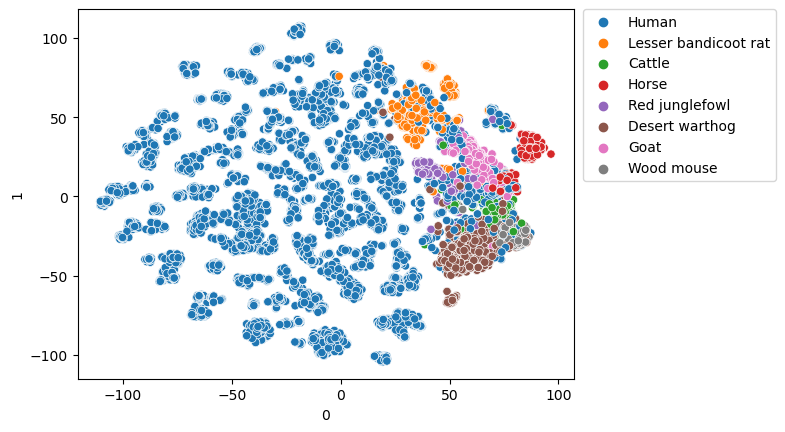

(TSNE(init='pca', learning_rate='auto', verbose=1),
                0           1  label
 0      21.892378   11.218695  Human
 1       8.822783  -15.839327  Human
 2      -2.406132  -93.931206  Human
 3     -64.732094   61.647072  Human
 4      20.924559 -101.610558  Human
 ...          ...         ...    ...
 15269  -2.591808  -89.159943  Human
 15270  69.822479    5.308790  Horse
 15271 -45.789898  -31.166794  Human
 15272   6.930057   32.886913  Human
 15273  29.408796  -88.648232  Human
 
 [14662 rows x 3 columns])

In [64]:
train_rep_df = compute_dataset_representations(pre_trained_transformer_encoder_model, train_dataset_loader)
visualize_dataset(train_rep_df)

##### Fine-tuned Model: TransformerEncoder for Host prediction

(15274, 513)
Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
           503,     504,     505,     506,     507,     508,     509,     510,
           511, 'label'],
      dtype='object', length=513)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15274 samples in 0.007s...
[t-SNE] Computed neighbors for 15274 samples in 8.417s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15274
[t-SNE] Computed conditional probabilities for sample 2000 / 15274
[t-SNE] Computed conditional probabilities for sample 3000 / 15274
[t-SNE] Computed conditional probabilities for sample 4000 / 15274
[t-SNE] Computed conditional probabilities for sample 5000 / 15274
[t-SNE] Computed conditional probabilities for sample 6000 / 15274
[t-SNE] Computed conditional probabilities for sample 7000 / 15274
[t-SNE] Computed conditional probabilities for sample 8000 / 15274
[t-SNE] Computed conditional probabilities for sample 

/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.825676
[t-SNE] KL divergence after 1000 iterations: 0.864410
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15274 samples in 0.008s...
[t-SNE] Computed neighbors for 15274 samples in 8.860s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15274
[t-SNE] Computed conditional probabilities for sample 2000 / 15274
[t-SNE] Computed conditional probabilities for sample 3000 / 15274
[t-SNE] Computed conditional probabilities for sample 4000 / 15274
[t-SNE] Computed conditional probabilities for sample 5000 / 15274
[t-SNE] Computed conditional probabilities for sample 6000 / 15274
[t-SNE] Computed conditional probabilities for sample 7000 / 15274
[t-SNE] Computed conditional probabilities for sample 8000 / 15274
[t-SNE] Computed conditional probabilities for sample 9000 / 15274
[t-SNE] Computed conditional probabilities for sample 10000 / 15274
[t-SNE] Computed conditional probabilities for sample 

/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.835121
[t-SNE] KL divergence after 1000 iterations: 0.864944
(15274, 2)
               0          1
0       6.116765  36.780499
1     -59.935902 -11.745872
2     -17.212545 -52.966583
3      67.865074  14.494096
4     -73.109146  -0.011070
...          ...        ...
15269 -63.342415 -14.120462
15270 -44.566246 -51.019089
15271  59.009518 -23.141680
15272 -24.578373  48.508698
15273 -33.090477 -79.042702

[15274 rows x 2 columns]


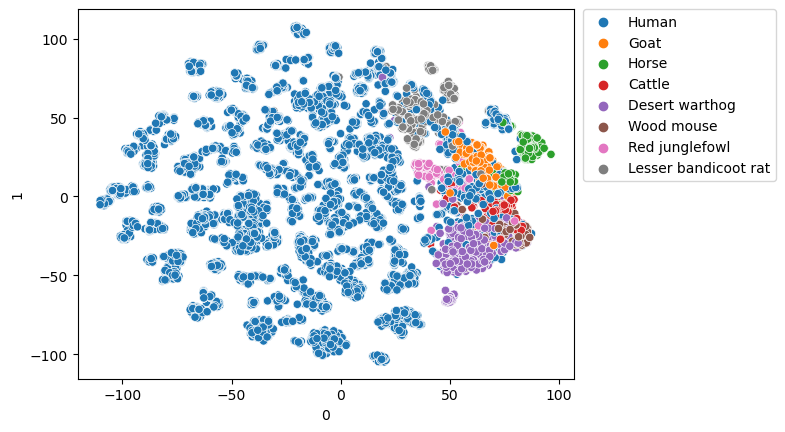

(TSNE(init='pca', learning_rate='auto', verbose=1),
                0          1           label
 0       6.116765  36.780499           Human
 1     -59.935902 -11.745872           Human
 2     -17.212545 -52.966583           Human
 3      67.865074  14.494096            Goat
 4     -73.109146  -0.011070           Human
 ...          ...        ...             ...
 15269 -63.342415 -14.120462           Human
 15270 -44.566246 -51.019089           Human
 15271  59.009518 -23.141680  Desert warthog
 15272 -24.578373  48.508698           Human
 15273 -33.090477 -79.042702           Human
 
 [14662 rows x 3 columns])

In [65]:
train_rep_df = compute_dataset_representations(fine_tuned_host_prediction_model.pre_trained_model, train_dataset_loader)
visualize_dataset(train_rep_df)